In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news_ria'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.0001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  88657 - количество слов в словаре
  21068 - количество слов в словаре после фильтрации по min_tf
  20685 - количество слов в словаре после фильтрации по max_tf
  20470 - количество слов в словаре после фильтрации по min_df_rate
  20470 - количество слов в словаре после фильтрации по max_df_rate


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [6]:
params = {
    'topic_count': 50,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

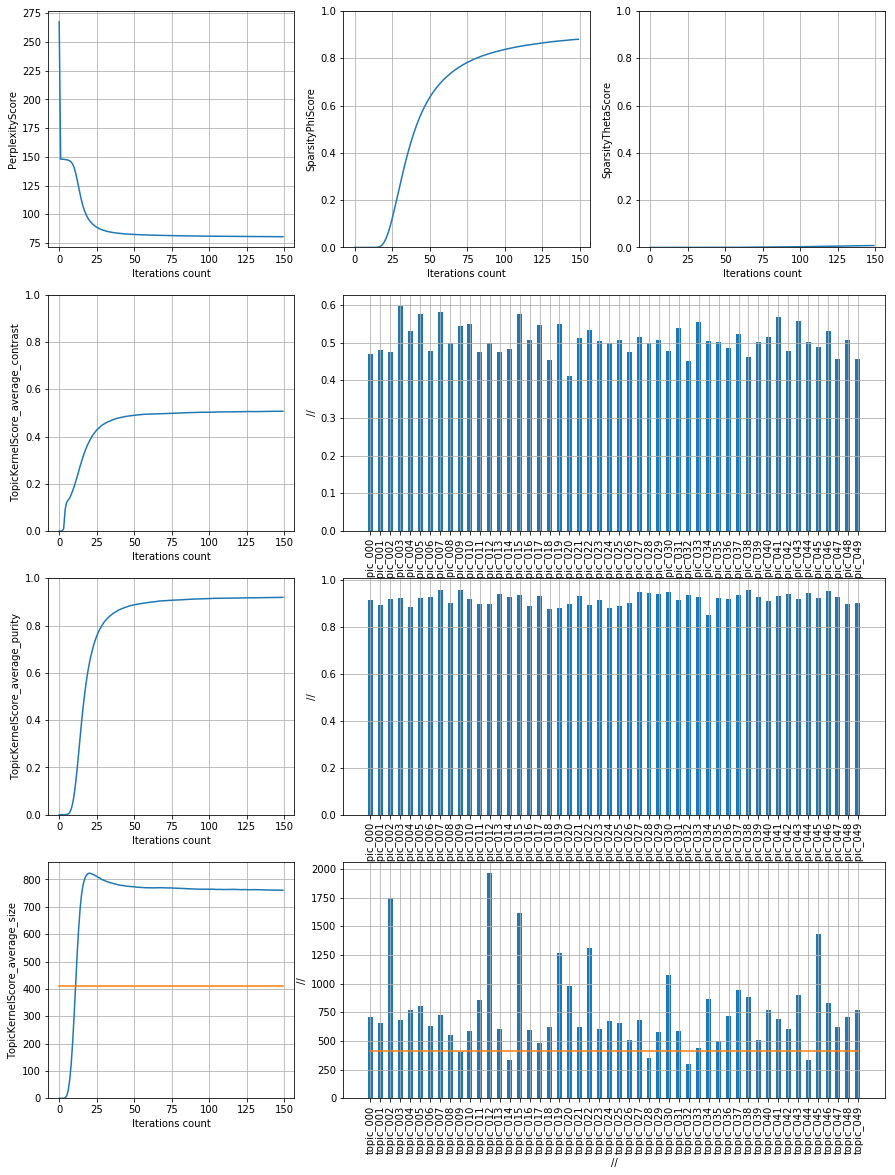

PerplexityScore: 80.5287857055664
SparsityPhiScore: 0.8810200095176697
SparsityThetaScore: 0.008115463890135288

TopicKernelScore_average_contrast: 0.5069840550422668
TopicKernelScore_average_purity: 0.9195989370346069
TopicKernelScore_average_size: 760.47998046875

TopTokensScore:
topic_000: индекс торги рейтинг ожидать биржа инвестор прогноз аналитик снижение свидетельствовать 
topic_001: пост кандидат голос голосование избирательный президентский отставка парламентский возглавлять избиратель 
topic_002: друг жить рука увидеть маленький отец глаз узнавать вещь голова 
topic_003: франция германия олимпийский сочи италия французский греция испания олимпиада нижний 
topic_004: ссылка египет турция ливия израиль боевик пресс посольство западный группировка 
topic_005: северный владивосток море река морской поиск корабль берег дальний флот 
topic_006: позиция важный интерес партнер точка диалог основа принцип свободный ассоциация 
topic_007: юрий николай игорь михаил евгений олег новосиби

In [7]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

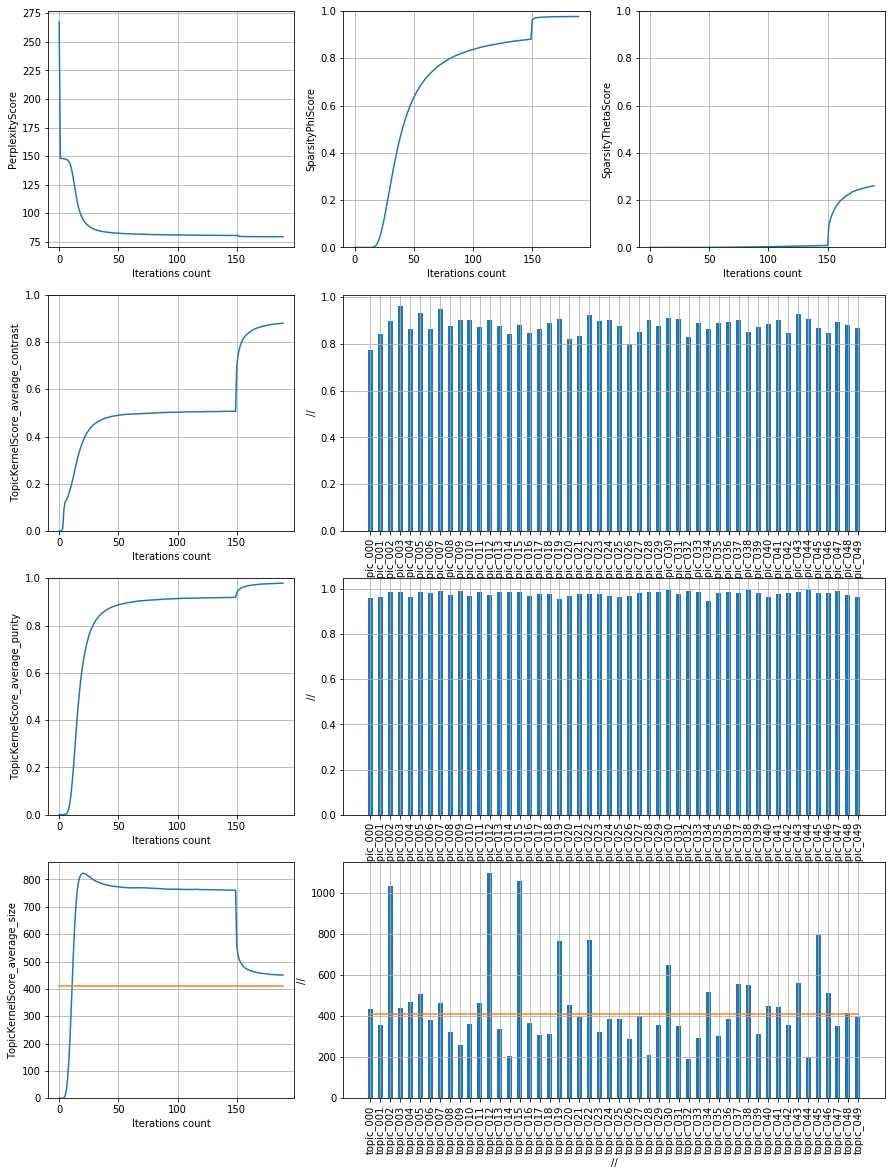

PerplexityScore: 79.47342681884766
SparsityPhiScore: 0.9770698547363281
SparsityThetaScore: 0.26100122928619385

TopicKernelScore_average_contrast: 0.8793247938156128
TopicKernelScore_average_purity: 0.979651927947998
TopicKernelScore_average_size: 450.2799987792969

TopTokensScore:
topic_000: индекс торги рейтинг ожидать снижение биржа инвестор прогноз аналитик свидетельствовать 
topic_001: пост кандидат голос президентский голосование избирательный возглавлять отставка парламентский избиратель 
topic_002: друг жить рука увидеть отец приходить маленький потом узнавать вещь 
topic_003: франция германия сочи олимпийский италия французский греция испания нижний олимпиада 
topic_004: ссылка египет турция ливия израиль боевик операция западный пресс группировка 
topic_005: северный владивосток море река морской поиск корабль берег дальний флот 
topic_006: позиция интерес важный партнер точка основа диалог принцип свободный ассоциация 
topic_007: юрий игорь михаил николай евгений олег новос

In [8]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

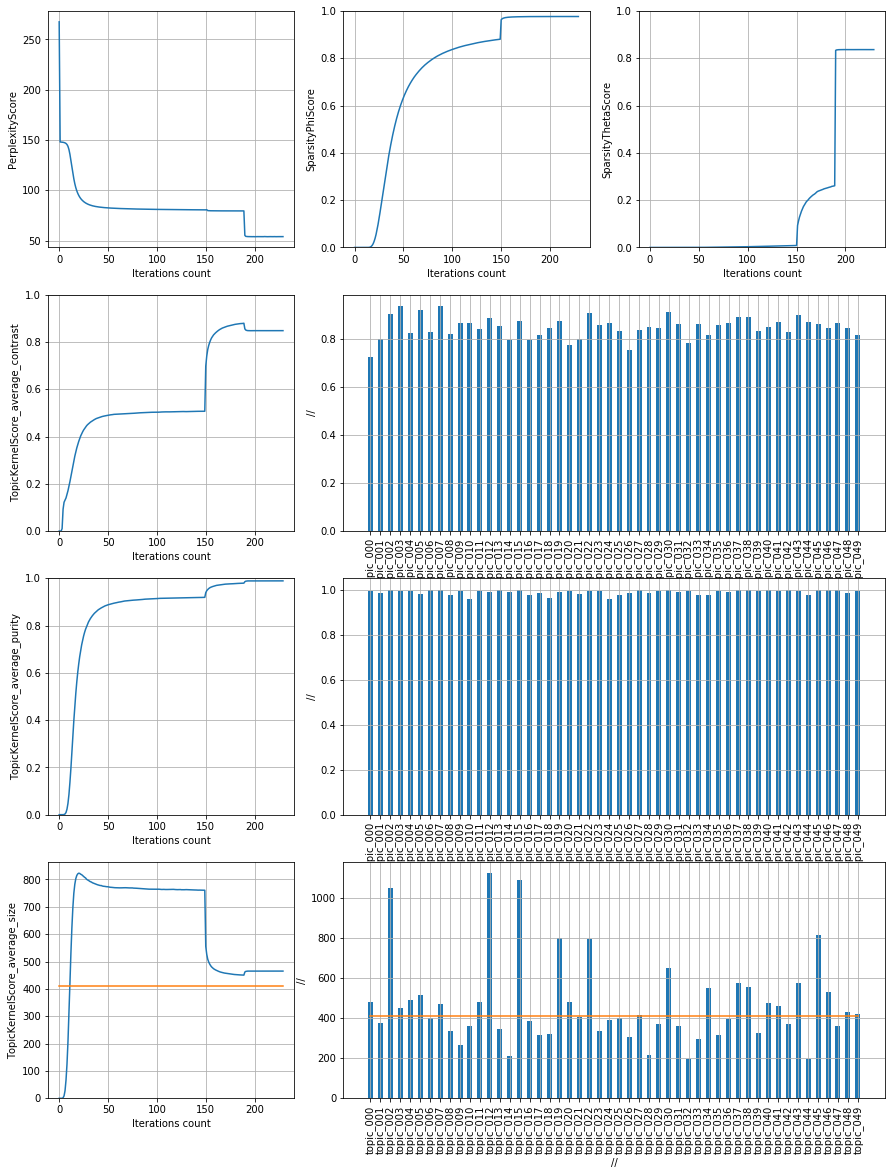

PerplexityScore: 53.90878677368164
SparsityPhiScore: 0.9770962595939636
SparsityThetaScore: 0.8370531797409058

TopicKernelScore_average_contrast: 0.8479636907577515
TopicKernelScore_average_purity: 0.9892874360084534
TopicKernelScore_average_size: 464.9599914550781

TopTokensScore:
topic_000: индекс торги рейтинг биржа аналитик ожидать прогноз инвестор снижение валюта 
topic_001: кандидат пост голос избирательный голосование президентский парламентский избиратель отставка кампания 
topic_002: друг жить рука приходиться собираться отец сразу уходить приезжать маленький 
topic_003: франция германия сочи италия олимпийский французский греция испания париж немецкий 
topic_004: египет ливия турция израиль боевик ирак ссылка пресс арабский израильский 
topic_005: владивосток море морской река северный корабль берег флот восток дальний 
topic_006: точка интерес партнер диалог позиция важный армения ассоциация принцип таможенный 
topic_007: юрий новосибирск игорь евгений николай михаил олег е

In [9]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

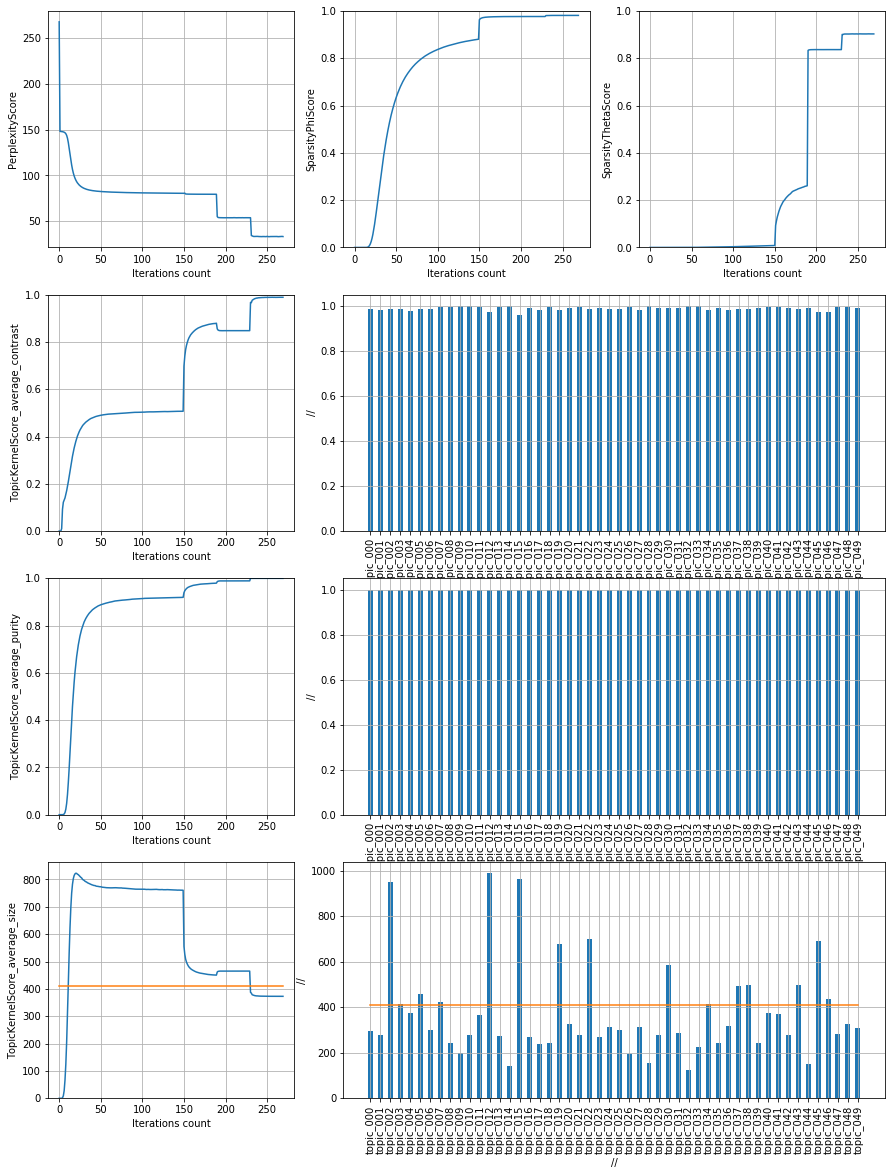

PerplexityScore: 33.347068786621094
SparsityPhiScore: 0.9817547798156738
SparsityThetaScore: 0.9034375548362732

TopicKernelScore_average_contrast: 0.9891221523284912
TopicKernelScore_average_purity: 0.9999166131019592
TopicKernelScore_average_size: 372.739990234375

TopTokensScore:
topic_000: индекс торги биржа аналитик фондовый валюта ожидать свидетельствовать бумага валютный 
topic_001: кандидат пост избирательный голосование голос президентский парламентский избиратель кандидатура кампания 
topic_002: жить рука отец маленький глаз вещь узнавать признаваться живой любить 
topic_003: франция германия сочи италия французский испания париж немецкий итальянский зимний 
topic_004: египет ливия турция израиль ирак израильский арабский турецкий ливийский каир 
topic_005: владивосток море река морской берег флот приморье наводнение приморский амурский 
topic_006: диалог точка армения партнер таможенный принцип молдавия зрение доклад свободный 
topic_007: юрий новосибирск игорь евгений олег 

In [10]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

In [11]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,...,topic_040,topic_041,topic_042,topic_043,topic_044,topic_045,topic_046,topic_047,topic_048,topic_049
карастелев,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000106,0.000000,0.0,0.0
гиббс,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000382,0.0,0.0
холбрук,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
тенге,0.001146,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
некляев,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000424,0.000000,0.0,0.0
змий,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
летальность,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
кровоточивость,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
геморрагия,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
касабланка,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0


In [12]:
theta = model_artm.get_theta()
theta

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,21990,21991,21992,21993,21994,21995,21996,21997,21998,21999
topic_000,1.110474e-02,7.853305e-04,3.736166e-09,0.000000e+00,1.951938e-02,2.088463e-03,1.681716e-02,0.000725,0.077314,7.145939e-03,...,2.476410e-02,0.015329,0.003367,1.632625e-03,1.416551e-02,3.441862e-02,6.563290e-03,5.584254e-14,0.000570,6.224024e-03
topic_001,1.929126e-01,1.941702e-08,1.928487e-04,1.242626e-03,1.075948e-07,4.902813e-04,6.863650e-02,0.035921,0.011447,2.632641e-03,...,1.786094e-03,0.016732,0.019944,3.034481e-03,3.198359e-03,2.329506e-03,3.810632e-03,8.851987e-02,0.002272,3.224493e-03
topic_002,4.822841e-03,1.794653e-02,1.267764e-03,2.180200e-03,1.033254e-02,1.069032e-02,5.160278e-03,0.006859,0.018323,1.646906e-02,...,3.140513e-03,0.015045,0.004984,1.204155e-04,2.278287e-04,4.024940e-03,1.394230e-02,2.570129e-09,0.004175,9.512582e-03
topic_003,4.557727e-02,7.588543e-05,1.337339e-04,0.000000e+00,2.374603e-09,9.892313e-03,1.048497e-03,0.005370,0.003313,2.083583e-03,...,1.067262e-02,0.010232,0.034173,1.768252e-03,8.659023e-08,3.005443e-02,4.903337e-02,1.568772e-01,0.013692,2.677513e-05
topic_004,3.387390e-03,9.470029e-04,1.856516e-03,2.819376e-02,3.243905e-03,5.060895e-02,2.614051e-01,0.001987,0.007380,2.705273e-03,...,2.743658e-02,0.008646,0.033802,4.338898e-04,2.077643e-03,8.135828e-03,8.447620e-05,7.474863e-03,0.001769,1.353621e-03
topic_005,7.113244e-07,3.905404e-03,5.548354e-04,1.200437e-01,1.420619e-01,1.338691e-05,1.028317e-05,0.011497,0.000512,3.033677e-03,...,7.177966e-03,0.000002,0.034671,2.203859e-01,7.571671e-03,1.356194e-03,1.409084e-03,2.576079e-03,0.002881,1.597607e-03
topic_006,2.537764e-03,3.856865e-02,7.348962e-05,1.618933e-10,1.114368e-02,2.762003e-02,4.801563e-04,0.021314,0.005564,6.094682e-03,...,3.810784e-02,0.016763,0.002974,4.389461e-04,1.229528e-01,1.326248e-02,3.829176e-02,8.148451e-03,0.003326,1.690913e-02
topic_007,2.266527e-02,2.463627e-10,1.387662e-01,2.339792e-04,1.326431e-02,4.256876e-08,1.131054e-04,0.004273,0.036372,3.899040e-03,...,7.459096e-03,0.020488,0.029725,2.622810e-03,5.404042e-03,3.054469e-06,1.126093e-03,2.668710e-02,0.001618,2.073623e-04
topic_008,1.485951e-02,3.034721e-06,1.110552e-03,2.084664e-02,4.092835e-10,9.186922e-03,2.501501e-02,0.020643,0.119845,4.198220e-03,...,8.033242e-03,0.001494,0.086915,2.125070e-03,1.310732e-03,1.223413e-02,8.657746e-03,1.658192e-03,0.003850,1.574149e-07
topic_009,1.910122e-05,6.106780e-11,7.639360e-02,3.591279e-02,4.775556e-03,7.931979e-03,1.745703e-04,0.056303,0.009060,3.027799e-02,...,6.931749e-07,0.009423,0.000037,2.185284e-03,3.581468e-05,2.691675e-02,6.762990e-05,2.871077e-08,0.054484,1.477484e-02
